# Feature Engineering with Clinical Data

A patient cohort undergoing septic shock during admissions was created from the [MIMIC III database](https://mimic.physionet.org/mimictables/patients/), which contains information on patient stays in the Intensive Care Unit of the Beth Israel Deaconess Medical Center (Boston, MA). Inclusion of patients in the cohort is determined by a set of "inclusion criteria" that qualify the time and eligibility of patients relevant to the study.

The goal is to predict whether septic shock will occur during the remainder of the admission 12 hours after admission with at least three hours of lead time. Features are built off the cohort developed in *Identification of a patient cohort based on inclusion criteria* and extracted from vitals, diagnosis codes, and more that can be used to predict the future development of septic shock. A set of features are then engineered and fed into the prediction model. Specifically, this feature engineering is done in eight categories: diagnoses, notes, heart rate measurements, antibiotics, prescriptions, blood pressure readings, gender and age, and various abnormal labs measurements. We surmise that these categories are crucial to predict septic shock accurately.

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# Set timezone to UTC
import os, time
os.environ['TZ'] = 'UTC'

import datetime
print(datetime.datetime.fromtimestamp(0).strftime('%Y-%m-%d %H:%M:%S'))

1969-12-31 18:00:00


In [3]:
# Load the data
cohort_labels = pd.read_csv('cohort_labels.csv')
admissions = pd.read_csv('ADMISSIONS.csv')

In [4]:
# Inner join on admissions and cohort_labels dataframes
sep_shock_start = admissions.merge(cohort_labels, left_on=['SUBJECT_ID', 'HADM_ID'],
                                   right_on=['subject_id', 'hadm_id'], how='inner')

# Select columns
sep_shock_start = sep_shock_start[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'charttime', 'septic_shock']]

# Convert ADMITTIME, DISCHTIME, charttime to datetime
sep_shock_start['ADMITTIME'] = pd.to_datetime(sep_shock_start['ADMITTIME']).dt.tz_localize(tz='UTC')
sep_shock_start['DISCHTIME'] = pd.to_datetime(sep_shock_start['DISCHTIME']).dt.tz_localize(tz='UTC')
sep_shock_start['charttime'] = pd.to_datetime(sep_shock_start['charttime'])

In [5]:
sep_shock_start.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,charttime,septic_shock
0,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 10:14:00+00:00,False
1,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 13:07:00+00:00,False
2,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 13:30:00+00:00,False
3,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 14:00:00+00:00,False
4,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 15:00:00+00:00,False


## Defining labels for prediction

The following definitions will be used:

* Labels will only be assigned to admissions of at least twelve hours in duration.
* An admission is assigned a negative label if septic shock does not occur at any time during the admission.
* An admission is assigned a positive label if septic shock occurs fifteen hours after admission or later.
* Admissions where the earliest time of septic shock occurs prior to fifteen hours after admission are removed from the study.
* For admissions that have valid labels, an index time is assined at twelve hours into the admission. For prediction, information is only used that occurs before the index time.
* In the case that a patient has multiple admissions for which a valid index time and label may be assigned, the latest admission is used.

In [6]:
# Add 'label' column
# Observations with '-99' label to be removed from study
# '0' label means unassigned

def case_when(row):   # row is a Series
    if (row.septic_shock == True) & ((row.charttime - row.ADMITTIME).total_seconds()/3600 >= 15):
        return 1
    elif (row.septic_shock == True) & ((row.charttime - row.ADMITTIME).total_seconds()/3600 < 15):
        return -99
    elif (row.septic_shock == False) & ((row.charttime - row.ADMITTIME).total_seconds()/3600 >= 12):
        return -1
    else:
        return 0

sshock_label = sep_shock_start.copy()
sshock_label['label'] = sshock_label.apply(case_when, axis = 1)

In [7]:
sshock_label.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,charttime,septic_shock,label
0,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 10:14:00+00:00,False,0
1,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 13:07:00+00:00,False,0
2,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 13:30:00+00:00,False,0
3,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 14:00:00+00:00,False,0
4,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,2196-04-09 15:00:00+00:00,False,0


In [8]:
# Remove observations with '0' and -99' label from master df
sshock_label_2 = sshock_label[~sshock_label['label'].isin([0, -99])].reset_index(drop = True)

In [9]:
# Set all labels within each SUBJECT_ID, HADM_ID = 1 if septic shock occurs at any time during admission
# Drop charttime, septic_shock columns
# Get unique SUBJECT_ID, HADM_ID observations

# Check to see if there is at least one septic shock label within SUBJECT_ID, HADM_ID
def check_sshock_adm(s):
    a = s.to_numpy()
    return (a[0] == a).all()

chk_sshock_label = pd.DataFrame(sshock_label_2.groupby(['SUBJECT_ID','HADM_ID'], as_index=False)['label']
                                .apply(check_sshock_adm))
chk_sshock_label.reset_index(inplace = True)
chk_sshock_label.rename(columns={0: 'lbl_chk'}, inplace=True)

# Join the septic shock label check df to the main df
sshock_label_2 = sshock_label_2.merge(chk_sshock_label, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Update 'label' column
sshock_label_2['label'] = np.where(sshock_label_2.lbl_chk == False, 1, sshock_label_2.label)

# Drop columns
sshock_label_2.drop(['charttime', 'septic_shock', 'lbl_chk'], axis = 1, inplace = True)

# Get unique observations per SUBJECT_ID, HADM_ID
sshock_label_2 = sshock_label_2.drop_duplicates(subset = ['SUBJECT_ID', 'HADM_ID']).reset_index(drop = True)

In [10]:
# Add index time, which is 12 hrs after latest ADMITTIME per SUBJECT_ID
max_adtime = sshock_label_2.groupby('SUBJECT_ID', as_index = False)['ADMITTIME'].max()

# Index time
max_adtime['index_time'] = max_adtime['ADMITTIME'] + datetime.timedelta(hours = 12)

# Drop ADMITTIME
max_adtime.drop('ADMITTIME', axis = 1, inplace = True)

# Join the max_adtime df to the main df
sshock_feat = sshock_label_2.merge(max_adtime, on=['SUBJECT_ID'], how='inner')

In [11]:
sshock_feat.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,label,index_time
0,22,165315,2196-04-09 12:26:00+00:00,2196-04-10 15:54:00+00:00,-1,2196-04-10 00:26:00+00:00
1,23,152223,2153-09-03 07:15:00+00:00,2153-09-08 19:10:00+00:00,-1,2157-10-19 07:34:00+00:00
2,23,124321,2157-10-18 19:34:00+00:00,2157-10-25 14:00:00+00:00,-1,2157-10-19 07:34:00+00:00
3,24,161859,2139-06-06 16:14:00+00:00,2139-06-09 12:48:00+00:00,-1,2139-06-07 04:14:00+00:00
4,25,129635,2160-11-02 02:06:00+00:00,2160-11-05 14:55:00+00:00,-1,2160-11-02 14:06:00+00:00


In [12]:
sshock_feat_short = sshock_feat[['SUBJECT_ID', 'HADM_ID', 'index_time', 'label']]

# Get unique observations per SUBJECT_ID, HADM_ID
sshock_feat_short = sshock_feat_short.drop_duplicates(subset = ['SUBJECT_ID', 'HADM_ID']
                                                     ).sort_values(['SUBJECT_ID', 'HADM_ID']
                                                                  ).reset_index(drop = True)

In [13]:
sshock_feat_short.head()

,SUBJECT_ID,HADM_ID,index_time,label
0,3,145834,2101-10-21 07:08:00+00:00,-1
1,4,185777,2191-03-16 12:28:00+00:00,-1
2,6,107064,2175-05-30 19:15:00+00:00,-1
3,9,150750,2149-11-10 01:06:00+00:00,-1
4,11,194540,2178-04-16 18:18:00+00:00,-1


In [14]:
# Total number of unique SUBJECT_ID's, HADM_ID's
sshock_feat_short[['SUBJECT_ID', 'HADM_ID']].nunique()

SUBJECT_ID     990
HADM_ID       1325
dtype: int64

**Number of admissions that receive a positive or negative label. The same patient can have multiple admissions.**

In [15]:
sshock_feat_short['label'].value_counts()

-1    1216
 1     109
Name: label, dtype: int64

## *Patient-Feature Matrix for the Septic Shock Cohort*

## Diagnoses

In [16]:
# Load the data
diagnoses_icd = pd.read_csv('DIAGNOSES_ICD.csv')

**Diagnosis time is the discharge time ('DISCHTIME')**

In [17]:
# Extract the columns in the final result after joining diagnoses and sshock_feat df's
diagnoses = sshock_feat.merge(diagnoses_icd, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
diagnoses = diagnoses[['SUBJECT_ID', 'HADM_ID', 'DISCHTIME', 'ICD9_CODE', 'index_time']]
diagnoses.rename(columns={'DISCHTIME': 'diagnosis_time'}, inplace=True)

In [18]:
diagnoses.head()

,SUBJECT_ID,HADM_ID,diagnosis_time,ICD9_CODE,index_time
0,22,165315,2196-04-10 15:54:00+00:00,9678,2196-04-10 00:26:00+00:00
1,22,165315,2196-04-10 15:54:00+00:00,9693,2196-04-10 00:26:00+00:00
2,22,165315,2196-04-10 15:54:00+00:00,E9502,2196-04-10 00:26:00+00:00
3,22,165315,2196-04-10 15:54:00+00:00,E9503,2196-04-10 00:26:00+00:00
4,22,165315,2196-04-10 15:54:00+00:00,3488,2196-04-10 00:26:00+00:00


In [19]:
# Filter the diagnoses for each patient that were recorded before the index time
diagnoses_prior = diagnoses[diagnoses['diagnosis_time'] < diagnoses['index_time']].reset_index(drop = True)

In [20]:
diagnoses_prior.head()

,SUBJECT_ID,HADM_ID,diagnosis_time,ICD9_CODE,index_time
0,23,152223,2153-09-08 19:10:00+00:00,41401,2157-10-19 07:34:00+00:00
1,23,152223,2153-09-08 19:10:00+00:00,4111,2157-10-19 07:34:00+00:00
2,23,152223,2153-09-08 19:10:00+00:00,4241,2157-10-19 07:34:00+00:00
3,23,152223,2153-09-08 19:10:00+00:00,V4582,2157-10-19 07:34:00+00:00
4,23,152223,2153-09-08 19:10:00+00:00,2724,2157-10-19 07:34:00+00:00


In [21]:
diagnoses_prior['SUBJECT_ID'].nunique()

198

In [22]:
diagnoses['SUBJECT_ID'].nunique()

990

**198 out of 990 total subjects have diagnoses recorded prior to the index_time. This means that ~20% of patient admissions have diagnoses/discharge times less than 12 hours after admissions.**

### Top 10 most common diagnosis codes (by number of unique patients who had the code in their history)

In [23]:
# Get unique ICD9 codes for each SUBJECT_ID
# Tally the ICD9 codes by number of unique SUBJECT_ID's
diagnoses_tally = diagnoses_prior.drop_duplicates(['SUBJECT_ID', 'ICD9_CODE']
                                                 ).groupby('ICD9_CODE', as_index = False
                                                          ).size().reset_index(name='n'
                                                                              ).sort_values('n', ascending = False
                                                                                           ).reset_index(drop = True)

In [24]:
diagnoses_tally.head(10)

,ICD9_CODE,n
0,4019,90
1,4280,78
2,41401,72
3,5849,64
4,42731,58
5,2859,44
6,51881,39
7,5990,38
8,25000,38
9,486,35


### Top 3 ICD9 codes

**4019 is unspecified essential hypertension.**  
**4280 is congestive heart failure, unspecified.**  
**41401 is coronary atherosclerosis of native coronary artery.**  
**All have a common theme in that they fall under the umbrella of cardiovascular diseases.**

### Distribution of the number of unique diagnostic patient histories

<AxesSubplot:xlabel='n', ylabel='Count'>

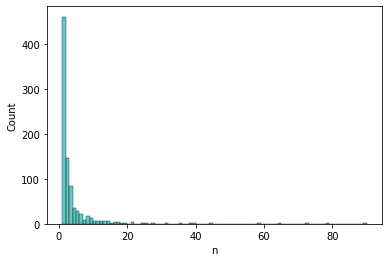

In [25]:
sns.histplot(data = diagnoses_tally, x = 'n', color = 'lightseagreen', alpha = 0.7, binwidth = 1)

### Information Content (IC)

Information Content is a measure of specificity based on the frequency of occurrence of features.

In [26]:
# Add Information Content calculation to diagnoses_tally
diagnoses_tally_ic = diagnoses_tally.copy()
n_sum = diagnoses_tally_ic['n'].sum()

# Calculate Information Content
def ic(x):
    return -math.log2(x.n / n_sum)

diagnoses_tally_ic['IC_ICD9'] = diagnoses_tally_ic.apply(ic, axis = 1)

In [27]:
diagnoses_tally_ic.head()

,ICD9_CODE,n,IC_ICD9
0,4019,90,5.080373
1,4280,78,5.286824
2,41401,72,5.402302
3,5849,64,5.572227
4,42731,58,5.714246


In [28]:
# Range (min) of IC's observed
diagnoses_tally_ic['IC_ICD9'].min()

5.08037341646402

In [29]:
# Range (max) of IC's observed
diagnoses_tally_ic['IC_ICD9'].max()

11.572226512793694

In [30]:
# Ten most specific ICD9 codes based on highest IC
diagnoses_tally_ic.sort_values('IC_ICD9', ascending = False).reset_index(drop = True).head(10)

,ICD9_CODE,n,IC_ICD9
0,2116,1,11.572227
1,E9344,1,11.572227
2,1984,1,11.572227
3,99603,1,11.572227
4,99602,1,11.572227
5,99593,1,11.572227
6,19889,1,11.572227
7,E8495,1,11.572227
8,E8499,1,11.572227
9,1121,1,11.572227


In [31]:
# Filter the set of ICD9 codes to those with an IC between 4 and 9
diagnoses_tally_ic_4_9 = diagnoses_tally_ic[diagnoses_tally_ic['IC_ICD9'].between(4, 9)]

In [32]:
diagnoses_tally_ic_4_9.head()

,ICD9_CODE,n,IC_ICD9
0,4019,90,5.080373
1,4280,78,5.286824
2,41401,72,5.402302
3,5849,64,5.572227
4,42731,58,5.714246


In [33]:
# Range (min) of IC's observed
diagnoses_tally_ic_4_9['IC_ICD9'].min()

5.08037341646402

In [34]:
# Range (max) of IC's observed
diagnoses_tally_ic_4_9['IC_ICD9'].max()

8.987264012072538

In [35]:
diagnoses_prior_ic_4_9 = diagnoses_prior.merge(diagnoses_tally_ic_4_9, on = 'ICD9_CODE', how = 'inner')
diagnoses_prior_ic_4_9.drop('n', axis = 1, inplace = True)

In [36]:
diagnoses_prior_ic_4_9.head()

,SUBJECT_ID,HADM_ID,diagnosis_time,ICD9_CODE,index_time,IC_ICD9
0,23,152223,2153-09-08 19:10:00+00:00,41401,2157-10-19 07:34:00+00:00,5.402302
1,34,115799,2186-07-20 16:00:00+00:00,41401,2191-02-23 17:23:00+00:00,5.402302
2,36,182104,2131-05-08 14:00:00+00:00,41401,2134-05-10 23:30:00+00:00,5.402302
3,36,122659,2131-05-25 13:30:00+00:00,41401,2134-05-10 23:30:00+00:00,5.402302
4,357,122609,2198-11-14 14:20:00+00:00,41401,2199-12-22 10:37:00+00:00,5.402302


### Patient-feature matrix time-binned by whether or not it occurred in the preceeding 6 months prior to the index time

In [37]:
# Add a column to see if diagnosis time is six months prior to index time
# 1 = six months prior
# 0 = not six months prior
diag_six_mo_prior = diagnoses.copy()
diag_six_mo_prior['six_mo_prior'] = np.where(
    (diag_six_mo_prior.diagnosis_time >= (diag_six_mo_prior.index_time - datetime.timedelta(days = 183))) &
    (diag_six_mo_prior.diagnosis_time < diag_six_mo_prior.index_time),
    1, 0)

In [38]:
# Get unique ICD9 codes for each SUBJECT_ID
# Tally the ICD9 codes by number of unique SUBJECT_ID's in bins of diagnosis time six months prior (1) or not (0)
diag_6_mo_tally = diag_six_mo_prior.drop_duplicates(['SUBJECT_ID', 'ICD9_CODE']
                                                        ).groupby(['ICD9_CODE', 'SUBJECT_ID', 'six_mo_prior'],
                                                                  as_index = False).size().reset_index(name='n'
                                                                                                      ).sort_values('n', ascending = False
                                                                                                                   ).reset_index(drop = True)

In [39]:
# Unite the ICD9_CODE and six_months_prior columns into one
diag_6_mo_tally['six_mo_prior'] = diag_6_mo_tally['six_mo_prior'].apply(str)
diag_6_mo_tally['ICD9_6_mo_before'] = (diag_6_mo_tally[['ICD9_CODE', 'six_mo_prior']].agg('_'.join, axis=1))

# Spread the table where this merged column is the key and n is the value
diag_6_mo_tally = pd.pivot_table(diag_6_mo_tally, columns='ICD9_6_mo_before', values='n',
                                 index=['SUBJECT_ID']).fillna(0).reset_index()

In [40]:
diag_6_mo_tally.head()

ICD9_6_mo_before,SUBJECT_ID,00845_0,00845_1,00869_0,0088_0,0090_0,0092_0,0093_0,0360_0,0362_0,...,V642_1,V6441_0,V6442_0,V644_0,V652_0,V667_0,V707_0,V8535_0,V8741_0,V8801_0
0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
diag_6_mo_tally.shape

(990, 2272)

In [42]:
# Load the data
noteevents = pd.read_csv('notes_small_cohort_v2.csv')

## Notes

In [43]:
noteevents.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,note_text
0,44005,3,145834,2101-10-31,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2101-10-20**] Discharg...
1,94503,3,145834,2101-10-21,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: S/P Car...
2,94502,3,145834,2101-10-21,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: Left ve...
3,272787,3,145834,2101-10-26,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nP-R interval increased\nLate R w...
4,769043,3,145834,2101-10-24,2101-10-24 08:05:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2101-10-24**] 8:05 AM\n CHEST (PORTABLE AP)...


In [44]:
noteevents = noteevents.merge(sshock_feat[['SUBJECT_ID', 'HADM_ID', 'index_time']],
                              left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'], how='inner')
noteevents.drop(['SUBJECT_ID', 'HADM_ID'], axis = 1, inplace = True)

In [45]:
noteevents.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,note_text,index_time
0,44005,3,145834,2101-10-31,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2101-10-20**] Discharg...,2101-10-21 07:08:00+00:00
1,94503,3,145834,2101-10-21,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: S/P Car...,2101-10-21 07:08:00+00:00
2,94502,3,145834,2101-10-21,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2101-10-21 07:08:00+00:00
3,272787,3,145834,2101-10-26,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm\nP-R interval increased\nLate R w...,2101-10-21 07:08:00+00:00
4,769043,3,145834,2101-10-24,2101-10-24 08:05:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2101-10-24**] 8:05 AM\n CHEST (PORTABLE AP)...,2101-10-21 07:08:00+00:00


In [46]:
# Filter noteevents where chartdate is one day prior to index_time
noteevents_prior = noteevents[
    pd.to_datetime(noteevents['chartdate']) < pd.Series(
        pd.DatetimeIndex(pd.to_datetime(noteevents['index_time']).dt.date
                        )) - datetime.timedelta(days=1)].reset_index(drop=True)

In [47]:
noteevents_prior.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,note_text,index_time
0,296510,12,112213,2104-08-05,NaN,NaN,ECG,Report,NaN,NaN,"Sinus bradycardia, rate 53. Right bundle-branc...",2104-08-07 22:15:00+00:00
1,51782,17,194023,2134-12-31,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2134-12-27**] ...,2135-05-10 02:11:00+00:00
2,297902,17,194023,2134-12-27,NaN,NaN,ECG,Report,NaN,NaN,Sinus rhythm. Normal ECG. Since the previous t...,2135-05-10 02:11:00+00:00
3,1260768,17,194023,2134-12-27,2134-12-27 23:10:00,2134-12-27 23:21:00,Nursing/other,Report,15630.0,NaN,OP DAY MINIMALLY INVASIVE PFO REPAIR\nNSR. NO ...,2135-05-10 02:11:00+00:00
4,1260769,17,194023,2134-12-28,2134-12-28 04:19:00,2134-12-28 04:30:00,Nursing/other,Report,14625.0,NaN,"Neuro: A&O X3,C/O incisional pain X1, medicate...",2135-05-10 02:11:00+00:00


In [48]:
# Number of notes present before filtering step
len(noteevents['note_text'])

39009

In [49]:
# Number of notes present after filtering step
len(noteevents_prior['note_text'])

11166

### Search of terms for inflammatory disorders using SNOMED CT hierarchy and UMLS terminologies

In [50]:
# Load the data
snomed_isa_closure = pd.read_csv('snomed_ct_isaclosure.csv')
snomed_cui_string = pd.read_csv('snomed_ct_str_cui.csv')

In [51]:
snomed_isa_closure.head()

,descendant,ancestor,dist
0,C0038891,C0038891,0
1,C0038891,C0220806,3
2,C0038891,C0033684,2
3,C0038891,C0023820,1
4,C0038891,C0029224,3


In [52]:
snomed_cui_string.head()

,tid,str,CUI
0,1,and,C1706368
1,2,0,C0919414
2,3,of,C0332285
3,3,of,C0456628
4,4,to,C1706540


### Find all terms for each CUI

In [53]:
# Join the terms df to the ancestor-descendant df by the descendant CUI
# Concept is the ancestor
# Term is the descendant
child_cui_terms = snomed_isa_closure.merge(snomed_cui_string, left_on='descendant', right_on='CUI', how='inner')
child_cui_terms.drop('CUI', axis = 1, inplace = True)
child_cui_terms.rename(columns={'tid': 'tid_descendant', 'str': 'str_descendant'}, inplace=True)

In [54]:
child_cui_terms.head()

,descendant,ancestor,dist,tid_descendant,str_descendant
0,C0038891,C0038891,0,239472,surfactant
1,C0038891,C0038891,0,265233,surfactant (substance)
2,C0038891,C0220806,3,239472,surfactant
3,C0038891,C0220806,3,265233,surfactant (substance)
4,C0038891,C0033684,2,239472,surfactant


### Inflammatory disorders dictionary of terms that have 20 characters or less

In [55]:
# Create inflammatory disorders dictionary of terms
inflammatory_dict = child_cui_terms[(child_cui_terms['ancestor'] == 'C1290884') &
                                    (child_cui_terms['str_descendant'].str.len() <= 20)].reset_index(drop=True)
uq_inflam_dict = inflammatory_dict.drop_duplicates(subset=['str_descendant'])

In [56]:
inflammatory_dict.head()

,descendant,ancestor,dist,tid_descendant,str_descendant
0,C0410126,C1290884,3,1186645,abscess of bursa-hip
1,C0032290,C1290884,5,7490,aspiration pneumonia
2,C0032290,C1290884,5,230348,inhalation pneumonia
3,C0034152,C1290884,5,239997,henoch's purpura
4,C0034152,C1290884,5,240003,autoimmune purpura


In [57]:
inflammatory_dict.shape

(3219, 5)

In [58]:
uq_inflam_dict['str_descendant'].shape

(2991,)

### First 50 unique terms in inflammatory disorders dictionary

In [59]:
# Create a list and a df containing the first 50 unique terms
terms_list = uq_inflam_dict['str_descendant'].head(50)
first_fifty = pd.DataFrame(terms_list)
first_fifty.rename(columns={'str_descendant': 'terms_list'}, inplace=True)
terms_list = terms_list.tolist()

# Create df with select info of noteevents from the 6 months prior to the index time
note_ids = noteevents_prior[['row_id', 'subject_id', 'chartdate', 'note_text']]

In [60]:
first_fifty

,terms_list
0,abscess of bursa-hip
1,aspiration pneumonia
2,inhalation pneumonia
3,henoch's purpura
4,autoimmune purpura
5,spring fever
6,tendinitis of wrist
7,tendonitis of wrist
8,tendinitis of hand
9,tendonitis of hand


In [61]:
note_ids.head()

,row_id,subject_id,chartdate,note_text
0,296510,12,2104-08-05,"Sinus bradycardia, rate 53. Right bundle-branc..."
1,51782,17,2134-12-31,Admission Date: [**2134-12-27**] ...
2,297902,17,2134-12-27,Sinus rhythm. Normal ECG. Since the previous t...
3,1260768,17,2134-12-27,OP DAY MINIMALLY INVASIVE PFO REPAIR\nNSR. NO ...
4,1260769,17,2134-12-28,"Neuro: A&O X3,C/O incisional pain X1, medicate..."


### Do any of the note texts contain each of the first fifty terms from the dictionary?

In [62]:
# Add in_notes column to check if note_text contains ANY of the 50 terms
term_in_notes = note_ids.rename(columns={'row_id': 'notes_id'})
term_in_notes['in_notes'] = np.where(term_in_notes['note_text'].str.lower().str.contains('|'.join(terms_list)),
                                     1, 0)

In [63]:
n_f50 = len(first_fifty.index)

# Create df that subsets all observations with NO terms in note_text
no_terms = term_in_notes[term_in_notes['in_notes']==0].drop(['note_text', 'in_notes'], axis = 1)

# Take observations with terms in note_text and now determine if EACH of the 50 terms is in the note_text
# To avoid OOM error, subject_id's with terms in note_text only are considered here
term_in_notes_2 = term_in_notes[term_in_notes['in_notes']==1]
term_in_notes_3 = pd.DataFrame(term_in_notes_2.values.repeat(n_f50, axis=0), columns=term_in_notes_2.columns)
term_in_notes_3['terms'] = pd.Series(np.resize(first_fifty['terms_list'], len(term_in_notes_3.index)))
term_in_notes_3['notes_term'] = np.where(term_in_notes_3.apply(lambda row: row['terms'] in row['note_text'],
                                                               axis=1), 1, 0)
term_in_notes_3.drop(['note_text', 'in_notes'], axis = 1, inplace = True)

# Spread df to show each term as a column with boolean values
term_in_notes_3 = pd.pivot_table(term_in_notes_3, columns='terms', values='notes_term',
                                 index=['notes_id', 'subject_id', 'chartdate']).reset_index()

# Append the observations from no_terms to complete the df
# Change NA's to 0's
term_in_notes_3 = term_in_notes_3.merge(no_terms,
                                        on = ['notes_id', 'subject_id', 'chartdate'], how = 'outer').fillna(0)

In [64]:
term_in_notes_3.head()

,notes_id,subject_id,chartdate,abscess of bursa-hip,abscess of heart,adenolymphangitis,allergic hepatitis,aspiration pneumonia,autoimmune purpura,bacterial cystitis,...,tendinitis of foot,tendinitis of hand,tendinitis of hip,tendinitis of knee,tendinitis of wrist,tendonitis of finger,tendonitis of foot,tendonitis of hand,tendonitis of hip,tendonitis of wrist
0,3966,605,2195-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14902,283,2166-09-12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15317,109,2137-11-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15318,109,2138-04-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15633,634,2116-12-28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
term_in_notes_3.shape

(11166, 53)

### Normalize terms back to their concepts

In [66]:
# Get observations from descendant-ancestor df with terms (descendant CUI's) associated with inflammatory disorders
concepts = child_cui_terms[child_cui_terms['str_descendant'].isin(terms_list)].reset_index(drop=True)

In [67]:
# Make df consisting of distinct concept CUI's associated with each patient
# Subject_id's with terms in notes only are considered here to avoid OOM error
notes_concepts = term_in_notes[term_in_notes['in_notes']==1]
notes_concepts_2 = pd.DataFrame(notes_concepts.values.repeat(n_f50, axis=0), columns=notes_concepts.columns)
notes_concepts_2['terms'] = pd.Series(np.resize(first_fifty['terms_list'], len(notes_concepts_2.index)))
notes_concepts_2['notes_term'] = np.where(notes_concepts_2.apply(lambda row: row['terms'] in row['note_text'],
                                                               axis=1), 1, 0)
notes_concepts_2.drop(['note_text', 'in_notes'], axis = 1, inplace = True)
notes_concepts_2 = notes_concepts_2[notes_concepts_2['notes_term']==1
                               ].merge(concepts, left_on='terms', right_on='str_descendant', how='inner')
notes_concepts_2.drop(['notes_id', 'terms', 'notes_term', 'descendant',
                       'dist', 'tid_descendant', 'str_descendant'],
                      axis = 1, inplace = True)
notes_concepts_2 = notes_concepts_2.rename(columns={'ancestor': 'concept'}
                                          ).drop_duplicates(['subject_id', 'concept'])

In [68]:
notes_concepts_2.head()

,subject_id,chartdate,concept
0,109,2142-06-02,C0032290
1,109,2142-06-02,C1761609
2,109,2142-06-02,C3661989
3,109,2142-06-02,C3661979
4,109,2142-06-02,C3714636


### Patient-feature matrix for presence or absence of concept

In [69]:
# There are some subject_id's in both no_terms df and notes_concepts df due to subject's multiple notes_id's
# In these cases, delete subject_id observations from the no_terms df
new_no_terms = no_terms.drop('notes_id', axis = 1
                            ).drop_duplicates('subject_id'
                                             ).merge(notes_concepts_2.drop('concept', axis = 1),
                                                     on='subject_id', how='outer', indicator=True)

# Anti-join equivalent
new_no_terms_2 = new_no_terms[new_no_terms['_merge'] == 'left_only'
                             ].drop(['chartdate_y', '_merge'], axis = 1
                                   ).rename(columns={'chartdate_x': 'chartdate'})

In [70]:
new_no_terms_2.head()

,subject_id,chartdate
0,12,2104-08-05
1,17,2134-12-31
2,21,2134-09-17
3,23,2153-09-08
4,34,2186-07-19


In [71]:
# Add a binary column with present = 1 for every concept CUI listed
# Spread df such that concept CUI's are now represented as columns with binary values
# Fill in NA's with 0's
concept_patient = notes_concepts_2.copy()
concept_patient['present'] = 1
concept_patient = pd.pivot_table(concept_patient,
                                 columns='concept', values='present', index=['subject_id', 'chartdate']
                                ).reset_index().merge(new_no_terms_2, on=['subject_id', 'chartdate'], how='outer'
                                                     ).drop('chartdate', axis = 1
                                                           ).fillna(0).sort_values('subject_id'
                                                                                  ).reset_index(drop=True)
concept_patient = concept_patient.astype('Int64')

In [72]:
concept_patient.head()

,subject_id,C0007682,C0009450,C0009566,C0010266,C0012634,C0013604,C0014236,C0015397,C0024115,...,C1298756,C1320354,C1320355,C1761609,C1960024,C2720507,C3661979,C3661989,C3714636,C3873618
0,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,34,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Dimensions of resulting dataframe
concept_patient.shape

(221, 91)

##  Patient Heart Rate Measurements

In [74]:
# Load the data
vitals_small_cohort = pd.read_csv('vitals_small_cohort.csv')

In [75]:
# Add index_time only from sshock_feat df after join to vitals_small_cohort
vitals_small_cohort = vitals_small_cohort.merge(sshock_feat[['SUBJECT_ID', 'HADM_ID', 'index_time']],
                                                left_on=['subject_id', 'hadm_id'],
                                                right_on=['SUBJECT_ID', 'HADM_ID'],
                                                how='inner').drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

In [76]:
vitals_small_cohort.head()

,subject_id,hadm_id,icustay_id,charttime,valuenum,vital_id,index_time
0,3,145834,211552,2101-10-20T19:15:00Z,217.0,SysBP,2101-10-21 07:08:00+00:00
1,3,145834,211552,2101-10-20T19:30:00Z,151.0,HeartRate,2101-10-21 07:08:00+00:00
2,3,145834,211552,2101-10-20T19:30:00Z,102.0,SysBP,2101-10-21 07:08:00+00:00
3,3,145834,211552,2101-10-20T19:45:00Z,135.0,HeartRate,2101-10-21 07:08:00+00:00
4,3,145834,211552,2101-10-20T19:45:00Z,94.0,SysBP,2101-10-21 07:08:00+00:00


In [77]:
vitals_small_cohort['subject_id'].nunique()

990

In [78]:
# Filter vitals_small_cohort where charttime is prior to index_time
vitals_small_cohort['charttime'] = pd.to_datetime(vitals_small_cohort['charttime'])
vitals_hr_prior = vitals_small_cohort[(vitals_small_cohort['vital_id']=='HeartRate') &
                                      (vitals_small_cohort['charttime'] < vitals_small_cohort['index_time'])
                                     ].rename(columns={'charttime': 'hr_charttime'}).reset_index(drop=True)

In [79]:
vitals_hr_prior.head()

,subject_id,hadm_id,icustay_id,hr_charttime,valuenum,vital_id,index_time
0,3,145834,211552,2101-10-20 19:30:00+00:00,151.0,HeartRate,2101-10-21 07:08:00+00:00
1,3,145834,211552,2101-10-20 19:45:00+00:00,135.0,HeartRate,2101-10-21 07:08:00+00:00
2,3,145834,211552,2101-10-20 20:00:00+00:00,143.0,HeartRate,2101-10-21 07:08:00+00:00
3,3,145834,211552,2101-10-20 20:15:00+00:00,165.0,HeartRate,2101-10-21 07:08:00+00:00
4,3,145834,211552,2101-10-20 20:30:00+00:00,168.0,HeartRate,2101-10-21 07:08:00+00:00


In [80]:
vitals_hr_prior['subject_id'].nunique()

765

### Latest heart rate before cutoff (index) time

In [81]:
# Order by ascending subject_id and descending charttime
# Take first observation for each subject_id = latest heart rate and charttime
recent_vitals_hr_prior = vitals_hr_prior.sort_values(['subject_id', 'hr_charttime'], ascending=[True, False]
                                                    ).groupby('subject_id').first().reset_index()
recent_vitals_hr_prior = recent_vitals_hr_prior[['subject_id', 'valuenum', 'hr_charttime']
                                               ].rename(columns={'valuenum': 'latest_heart_rate'})

In [82]:
recent_vitals_hr_prior.head()

,subject_id,latest_heart_rate,hr_charttime
0,3,97.0,2101-10-21 07:05:00+00:00
1,4,86.0,2191-03-16 12:00:00+00:00
2,9,92.0,2149-11-10 01:00:00+00:00
3,11,78.0,2178-04-16 18:00:00+00:00
4,13,62.0,2167-01-09 06:00:00+00:00


In [83]:
# Latest recorded heart rate average
recent_vitals_hr_prior['latest_heart_rate'].mean()

84.44836601307189

In [84]:
# Prepare df to make density plot
# Add label to df and rename it 'septic_shock'
recent_vitals_hr_label = recent_vitals_hr_prior.merge(
    sshock_feat[['SUBJECT_ID', 'label']],
    left_on='subject_id',
    right_on='SUBJECT_ID',
    how='inner').drop('SUBJECT_ID', axis=1).drop_duplicates('subject_id').rename(columns={'label': 'septic_shock'})

In [85]:
recent_vitals_hr_label.head()

,subject_id,latest_heart_rate,hr_charttime,septic_shock
0,3,97.0,2101-10-21 07:05:00+00:00,-1
1,4,86.0,2191-03-16 12:00:00+00:00,-1
2,9,92.0,2149-11-10 01:00:00+00:00,-1
3,11,78.0,2178-04-16 18:00:00+00:00,-1
4,13,62.0,2167-01-09 06:00:00+00:00,-1


Text(0.5, 1.0, 'Density Plot for Latest Heart Rate')

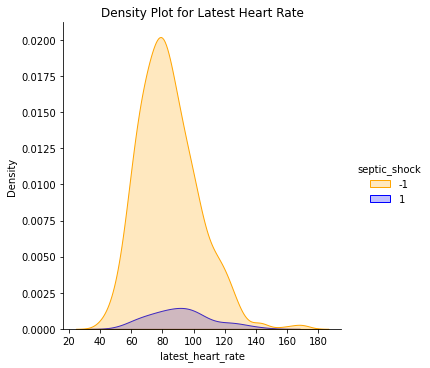

In [86]:
sns.displot(recent_vitals_hr_label, x='latest_heart_rate', hue='septic_shock',
            palette=['orange', 'blue'], kind='kde', fill=True)

plt.title('Density Plot for Latest Heart Rate')

### Septic shock and time difference between latest heart rate and cutoff time

In [87]:
# Create df with time difference
recent_hr_time_diff = vitals_hr_prior.sort_values(['subject_id', 'hr_charttime'], ascending=[True, False]
                                                 ).groupby('subject_id').first().reset_index()
recent_hr_time_diff = recent_hr_time_diff[['subject_id', 'valuenum', 'hr_charttime', 'index_time']
                                         ].rename(columns={'valuenum': 'latest_heart_rate'})
recent_hr_time_diff['time_diff_min'] = (recent_hr_time_diff['index_time'] - recent_hr_time_diff['hr_charttime']
                                       ).astype('timedelta64[m]')

In [88]:
# Add label to df
recent_hr_time_diff_label = recent_hr_time_diff.merge(
    sshock_feat[['SUBJECT_ID', 'label']],
    left_on='subject_id',
    right_on='SUBJECT_ID',
    how='inner').drop('SUBJECT_ID', axis=1).drop_duplicates('subject_id').rename(columns={'label': 'septic_shock'})

In [89]:
recent_hr_time_diff_label.head()

,subject_id,latest_heart_rate,hr_charttime,index_time,time_diff_min,septic_shock
0,3,97.0,2101-10-21 07:05:00+00:00,2101-10-21 07:08:00+00:00,3.0,-1
1,4,86.0,2191-03-16 12:00:00+00:00,2191-03-16 12:28:00+00:00,28.0,-1
2,9,92.0,2149-11-10 01:00:00+00:00,2149-11-10 01:06:00+00:00,6.0,-1
3,11,78.0,2178-04-16 18:00:00+00:00,2178-04-16 18:18:00+00:00,18.0,-1
4,13,62.0,2167-01-09 06:00:00+00:00,2167-01-09 06:43:00+00:00,43.0,-1


Text(0.5, 1.0, 'Density Plot for Time Difference of Latest Heart Rate')

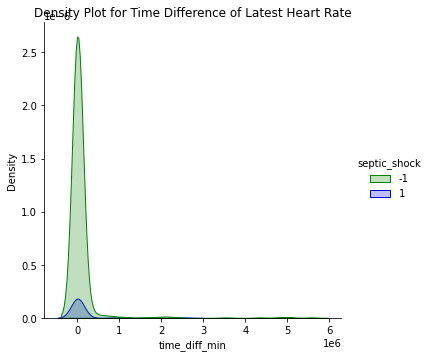

In [90]:
sns.displot(recent_hr_time_diff_label, x='time_diff_min', hue='septic_shock',
            palette=['green', 'blue'], kind='kde', fill=True)

plt.title('Density Plot for Time Difference of Latest Heart Rate')

### Time-weighted average heart rate

In [91]:
# Create df of time-weighted average heart rate per patient
hr_wght = vitals_hr_prior[['subject_id', 'valuenum', 'hr_charttime', 'index_time']
                         ].rename(columns={'valuenum': 'heart_rate'})
hr_wght['w'] = np.exp(-abs(round(((hr_wght['index_time'] - hr_wght['hr_charttime']
                                  ).dt.total_seconds() / 3600), 4))) - 1

def hr_weight(x):
    return (x.heart_rate * x.w).sum() / x.w.sum()

hr_wghted_avg = hr_wght.groupby('subject_id').apply(hr_weight).reset_index().rename(columns={0: 'hr_wgt_avg'})

In [92]:
hr_wghted_avg.head()

,subject_id,hr_wgt_avg
0,3,134.805188
1,4,87.286707
2,9,88.831464
3,11,89.228227
4,13,74.093074


In [93]:
# Average time-weighted average heart rate across all patients
time_wgted_avg_all_patients = hr_wghted_avg['hr_wgt_avg'].mean()
time_wgted_avg_all_patients

84.74754717052629

### Are the time-weighted average heart rate and the latest recorded heart rate similar?

In [94]:
wgt_avg_hr_time = hr_wghted_avg.merge(recent_hr_time_diff_label[['subject_id',
                                                                 'latest_heart_rate', 
                                                                 'time_diff_min']],
                                      on = 'subject_id', how = 'inner')

In [95]:
wgt_avg_hr_time.head()

,subject_id,hr_wgt_avg,latest_heart_rate,time_diff_min
0,3,134.805188,97.0,3.0
1,4,87.286707,86.0,28.0
2,9,88.831464,92.0,6.0
3,11,89.228227,78.0,18.0
4,13,74.093074,62.0,43.0


In [96]:
wgt_avg_hr_time.shape

(765, 4)

<function matplotlib.pyplot.show(close=None, block=None)>

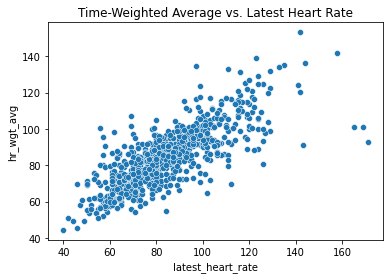

In [97]:
# Scatter plot of time-weighted average vs. latest heart rate
sns.scatterplot(data = wgt_avg_hr_time, x = 'latest_heart_rate', y = 'hr_wgt_avg')
plt.title('Time-Weighted Average vs. Latest Heart Rate')
plt.show

## Patient-feature matrix of diagnoses, notes, and heart rate measurements

In [98]:
diag_6_mo_tally = diag_6_mo_tally.rename(columns={'SUBJECT_ID': 'subject_id'})

# Combine the columns of the feature matrices from diagnoses, notes, and heart rate measurements
X = wgt_avg_hr_time.merge(concept_patient, on = 'subject_id', how = 'outer'
                         ).merge(diag_6_mo_tally, on = 'subject_id', how = 'outer')

# Fill in any NA values with 0 to indicate that there were no diagnoses or notes counted
X = X.fillna(0).sort_values('subject_id').reset_index(drop=True)

X_col_names = X.columns.tolist()

In [99]:
# Column names
X_col_names

['subject_id',
 'hr_wgt_avg',
 'latest_heart_rate',
 'time_diff_min',
 'C0007682',
 'C0009450',
 'C0009566',
 'C0010266',
 'C0012634',
 'C0013604',
 'C0014236',
 'C0015397',
 'C0024115',
 'C0027765',
 'C0027813',
 'C0029132',
 'C0029134',
 'C0030353',
 'C0032285',
 'C0032290',
 'C0032300',
 'C0035204',
 'C0035243',
 'C0035309',
 'C0035333',
 'C0037088',
 'C0038999',
 'C0039978',
 'C0042790',
 'C0149725',
 'C0155287',
 'C0161836',
 'C0178264',
 'C0205721',
 'C0235024',
 'C0242420',
 'C0270933',
 'C0271352',
 'C0274432',
 'C0278230',
 'C0339383',
 'C0422878',
 'C0423216',
 'C0423377',
 'C0423451',
 'C0425442',
 'C0442874',
 'C0521530',
 'C0575141',
 'C0575479',
 'C0577560',
 'C0577583',
 'C0577596',
 'C0577597',
 'C0577910',
 'C0577914',
 'C0578491',
 'C0578533',
 'C0578576',
 'C0578652',
 'C0579140',
 'C0729704',
 'C0730122',
 'C0744631',
 'C0751402',
 'C0876973',
 'C0949083',
 'C1263861',
 'C1285159',
 'C1285331',
 'C1285332',
 'C1285333',
 'C1285337',
 'C1285340',
 'C1290325',
 'C1290

In [100]:
# Convert all columns except for 'hr_wgt_avg' from float to integer values
X_col_names.remove('hr_wgt_avg')
X[X_col_names] = X[X_col_names].astype('Int64')

In [101]:
X.head()

,subject_id,hr_wgt_avg,latest_heart_rate,time_diff_min,C0007682,C0009450,C0009566,C0010266,C0012634,C0013604,...,V642_1,V6441_0,V6442_0,V644_0,V652_0,V667_0,V707_0,V8535_0,V8741_0,V8801_0
0,3,134.805188,97,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,87.286707,86,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,88.831464,92,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,89.228227,78,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
# Dimensions of resulting dataframe
X.shape

(992, 2365)

## Antibiotics

In [103]:
# Load the data
microbio = pd.read_csv('microbiologyevents_additional.csv')

In [104]:
# Construct antibiotics df and add index_time to it
antibiotics = sshock_feat.merge(microbio,
                                left_on=['SUBJECT_ID', 'HADM_ID'],
                                right_on=['subject_id', 'hadm_id'],
                                how='inner').drop(['subject_id', 'hadm_id'], axis=1)
antibiotics = antibiotics[['SUBJECT_ID', 'HADM_ID', 'chartdate', 'ab_name', 'index_time']
                         ].rename(columns={'chartdate': 'ab_date'})
antibiotics['ab_date'] = pd.to_datetime(antibiotics['ab_date'])

In [105]:
antibiotics.head()

,SUBJECT_ID,HADM_ID,ab_date,ab_name,index_time
0,22,165315,2196-04-09 00:00:00+00:00,NaN,2196-04-10 00:26:00+00:00
1,23,152223,2153-09-04 00:00:00+00:00,NaN,2157-10-19 07:34:00+00:00
2,23,124321,2157-10-24 00:00:00+00:00,NaN,2157-10-19 07:34:00+00:00
3,25,129635,2160-11-02 00:00:00+00:00,NaN,2160-11-02 14:06:00+00:00
4,25,129635,2160-11-02 00:00:00+00:00,NaN,2160-11-02 14:06:00+00:00


In [106]:
# Filter the specimen type for each patient that were recorded before the index time
ab_prior = antibiotics.groupby('SUBJECT_ID', as_index=False).filter(lambda x: (x.ab_date < x.index_time).any())

In [107]:
antibiotics['SUBJECT_ID'].nunique()

738

In [108]:
ab_prior['SUBJECT_ID'].nunique()

567

### Antibiotics time-binned by whether or not it occurred in the preceeding 6 months prior to the index time

In [109]:
# Add a column to see if specimen date is six months prior to index time
# 1 = six months prior
# 0 = not six months prior
ab_six_mo_prior = antibiotics.copy()
ab_six_mo_prior['six_mo_prior'] = np.where(
    (ab_six_mo_prior.ab_date >= (ab_six_mo_prior.index_time - datetime.timedelta(days = 183))) &
    (ab_six_mo_prior.ab_date < ab_six_mo_prior.index_time),
    1, 0)

In [110]:
# Get unique specimen types for each SUBJECT_ID
# Tally the specimen types by number of unique SUBJECT_ID's in bins of specimen date six months prior (1) or not (0)
ab_6_mo_tally = ab_six_mo_prior.drop_duplicates(['SUBJECT_ID', 'ab_name']
                                               ).groupby(['ab_name', 'SUBJECT_ID', 'six_mo_prior'],
                                                         as_index = False).size().reset_index(name='n'
                                                                                             ).sort_values('n', ascending = False
                                                                                                          ).reset_index(drop = True)

In [111]:
ab_6_mo_tally.head()

,ab_name,SUBJECT_ID,six_mo_prior,n
0,AMIKACIN,191,1,1
1,OXACILLIN,1018,1,1
2,OXACILLIN,1037,0,1
3,OXACILLIN,1041,0,1
4,OXACILLIN,1053,0,1


In [112]:
# Unite the ICD9_CODE and six_months_prior columns into one
ab_6_mo_tally['six_mo_prior'] = ab_6_mo_tally['six_mo_prior'].apply(str)
ab_6_mo_tally['ab_name_6_mo_before'] = (ab_6_mo_tally[['ab_name', 'six_mo_prior']].agg('_'.join, axis=1))

# Spread the table where this merged column is the key and n is the value
ab_6_mo_tally = pd.pivot_table(ab_6_mo_tally, columns='ab_name_6_mo_before', values='n',
                                 index=['SUBJECT_ID']).fillna(0).reset_index()

In [113]:
ab_6_mo_tally.head()

ab_name_6_mo_before,SUBJECT_ID,AMIKACIN_0,AMIKACIN_1,AMPICILLIN/SULBACTAM_0,AMPICILLIN/SULBACTAM_1,AMPICILLIN_0,AMPICILLIN_1,CEFAZOLIN_0,CEFAZOLIN_1,CEFEPIME_0,...,RIFAMPIN_0,RIFAMPIN_1,TETRACYCLINE_0,TETRACYCLINE_1,TOBRAMYCIN_0,TOBRAMYCIN_1,TRIMETHOPRIM/SULFA_0,TRIMETHOPRIM/SULFA_1,VANCOMYCIN_0,VANCOMYCIN_1
0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,31,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [114]:
ab_6_mo_tally.shape

(312, 58)

## Prescriptions

In [115]:
# Load the data
prescription = pd.read_csv('prescriptions_additional.csv')

C:\Users\joe_y\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Vasopressor drugs used and duration to treat septic shock

In [116]:
# Construct a patient-feature drugs df that displays the drugs that treat septic shock and the drug administration times per patient
# Replace NA's with 0's

# Drugs for septic shock treatment
sshock_drugs = ['norepinephrine', 'dopamine', 'epinephrine', 'phenylephrine', 'vasopressin']

drugs = prescription[prescription['drug'].str.lower().isin(sshock_drugs)]
drugs = drugs[['subject_id', 'startdate', 'enddate', 'drug']]
drugs['drug'] = drugs['drug'].str.lower()
drugs['drug_startend_time_diff_min'] = (pd.to_datetime(drugs['enddate']) -
                                        pd.to_datetime(drugs['startdate'])).dt.total_seconds() / 60
drugs.drop(['startdate', 'enddate'], axis = 1, inplace = True)
drugs = drugs.groupby(['subject_id', 'drug'], as_index=False)['drug_startend_time_diff_min'].max()

drugs = pd.pivot_table(drugs, columns='drug', values='drug_startend_time_diff_min',
                       index=['subject_id']).fillna(0).astype(np.int64).reset_index()

drug_name = drugs.columns.drop('subject_id')
drugs.columns = np.where(drugs.columns.isin(drug_name), drugs.columns + '_min', drugs.columns)

In [117]:
drugs.head()

,subject_id,dopamine_min,epinephrine_min,norepinephrine_min,phenylephrine_min,vasopressin_min
0,9,0,0,2880,0,0
1,21,0,0,8640,0,1440
2,25,0,0,1440,0,0
3,28,0,1440,0,0,0
4,31,0,0,8640,0,0


In [118]:
drugs.shape

(229, 6)

## Blood Pressure Measurements

In [119]:
# Load the data
d_items = pd.read_csv('d_items_additional.csv')
chartevents_1 = pd.read_csv('chartevents_1_additional.csv')

In [120]:
# Make df of arterial BP mean chartevent that is before index time
chart_1_prior = d_items[['itemid', 'label', 'linksto']].merge(chartevents_1, on='itemid', how='inner')
chart_1_prior = chart_1_prior[(chart_1_prior['linksto'] == 'chartevents') &
                              (chart_1_prior['label'] == 'Arterial BP Mean')]
chart_1_prior = chart_1_prior.merge(sshock_feat[['SUBJECT_ID', 'HADM_ID', 'index_time']],
             left_on='subject_id', right_on='SUBJECT_ID', how='inner')
chart_1_prior['charttime'] = pd.to_datetime(chart_1_prior['charttime'])
chart_1_prior = chart_1_prior[chart_1_prior['charttime'] < chart_1_prior['index_time']].reset_index(drop=True)
chart_1_prior = chart_1_prior[['subject_id', 'valuenum', 'charttime', 'index_time']
                             ].rename(columns={'valuenum': 'arterial_bp_mean'})

In [121]:
chart_1_prior['subject_id'].nunique()

426

### Latest blood pressure reading before cutoff (index) time and time difference

In [122]:
# Order by ascending subject_id and descending charttime
# Take first observation for each subject_id = latest arterial bp mean and charttime that is not NA
recent_bp_prior = chart_1_prior.sort_values(['subject_id', 'charttime'],
                                            ascending=[True, False]
                                           ).groupby('subject_id', as_index=False
                                                    ).filter(lambda x: ((x.arterial_bp_mean.notna()) &
                                                                        (x.charttime==x.charttime.max())).any()
                                                            ).groupby('subject_id', as_index=False
                                                                     ).first().reset_index()
recent_bp_prior['time_diff_min'] = (recent_bp_prior['index_time'] - recent_bp_prior['charttime']
                               ).dt.total_seconds() / 60
recent_bp_prior = recent_bp_prior[['subject_id', 'arterial_bp_mean', 'charttime', 'index_time', 'time_diff_min']
                                 ].rename(columns={'arterial_bp_mean': 'latest_bp_mean_mmHg'})
recent_bp_prior[['latest_bp_mean_mmHg', 'time_diff_min']
               ] = recent_bp_prior[['latest_bp_mean_mmHg', 'time_diff_min']].astype(np.int64)

In [123]:
recent_bp_prior.head()

,subject_id,latest_bp_mean_mmHg,charttime,index_time,time_diff_min
0,3,68,2101-10-21 07:05:00+00:00,2101-10-21 07:08:00+00:00,3
1,9,98,2149-11-10 01:00:00+00:00,2149-11-10 01:06:00+00:00,6
2,13,102,2167-01-09 06:00:00+00:00,2167-01-09 06:43:00+00:00,43
3,17,86,2135-05-10 02:00:00+00:00,2135-05-10 02:11:00+00:00,11
4,20,81,2183-04-28 21:30:00+00:00,2183-04-28 21:45:00+00:00,15


In [124]:
# Latest arterial BP average
recent_bp_prior['latest_bp_mean_mmHg'].mean()

82.21067415730337

In [125]:
chart_1_prior.head()

,subject_id,arterial_bp_mean,charttime,index_time
0,3,77.0,2101-10-21 00:00:00+00:00,2101-10-21 07:08:00+00:00
1,3,76.0,2101-10-21 01:00:00+00:00,2101-10-21 07:08:00+00:00
2,3,89.0,2101-10-21 02:00:00+00:00,2101-10-21 07:08:00+00:00
3,3,61.0,2101-10-20 20:30:00+00:00,2101-10-21 07:08:00+00:00
4,3,89.0,2101-10-21 04:00:00+00:00,2101-10-21 07:08:00+00:00


### Time-weighted average blood pressure reading

In [126]:
# Create df of time-weighted average BP, latest BP mean, and latest BP mean time difference per patient
bp_info = chart_1_prior.copy()
bp_info['w'] = np.exp(-abs(round(((bp_info['index_time'] - bp_info['charttime']
                                  ).dt.total_seconds() / 3600), 4))) - 1

def bp_weight(x):
    return (x.arterial_bp_mean * x.w).sum() / x.w.sum()

bp_info = pd.DataFrame(bp_info.drop(['charttime', 'index_time'], axis=1
                       ).groupby('subject_id'
                                ).apply(bp_weight).reset_index().rename(columns={0: 'bp_wgt_avg_mmHg'})
                      ).merge(recent_bp_prior[['subject_id', 'latest_bp_mean_mmHg', 'time_diff_min']],
                              on='subject_id', how='left')
bp_info = bp_info.rename(columns={'time_diff_min': 'bp_time_diff_min'})
bp_info[['latest_bp_mean_mmHg', 'bp_time_diff_min']] = bp_info[['latest_bp_mean_mmHg', 'bp_time_diff_min']
                                                           ].astype('Int64')

In [127]:
bp_info.head()

,subject_id,bp_wgt_avg_mmHg,latest_bp_mean_mmHg,bp_time_diff_min
0,3,84.729552,68,3
1,9,101.408216,98,6
2,13,92.177636,102,43
3,17,73.524863,86,11
4,20,73.554105,81,15


In [128]:
bp_info.shape

(426, 4)

In [129]:
bp_info['bp_wgt_avg_mmHg'].mean()

80.26819485888437

### Are the time-weighted average and latest recorded blood pressure readings similar?

<function matplotlib.pyplot.show(close=None, block=None)>

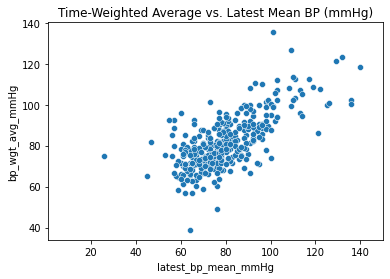

In [130]:
# Scatter plot of time-weighted average vs. latest mean arterial BP
fig, ax = plt.subplots()
sns.scatterplot(data = bp_info, x = 'latest_bp_mean_mmHg', y = 'bp_wgt_avg_mmHg')
ax.set_xlim(1,150)
plt.title('Time-Weighted Average vs. Latest Mean BP (mmHg)')
plt.show

## Gender and Age

In [131]:
# Load the data
patients = pd.read_csv('patients_additional.csv')

In [132]:
# Calculate average age (in years) per patient at time of admission
# Adjust age for elderly patients (~90 yrs old)
patients['dob'] = pd.to_datetime(patients['dob'])

age = patients[['subject_id', 'dob']
              ].merge(sshock_feat[['SUBJECT_ID', 'ADMITTIME']],
                      left_on='subject_id', right_on='SUBJECT_ID', how='inner'
                     ).drop('SUBJECT_ID', axis=1)

age['age_years'] = ((age['ADMITTIME'].dt.date - age['dob'].dt.date
                    ).astype('timedelta64[D]').dt.total_seconds() / (3600*24*365))
age['age_years'] = np.where(age['age_years'] <= -275, (age['age_years'] + 375), age['age_years'])
age = age.drop(['dob', 'ADMITTIME'], axis = 1).groupby('subject_id', as_index = False)['age_years'].mean()

In [133]:
# Put together gender and age columns with unique patients listed as rows
age_gender = patients[['subject_id', 'gender']].merge(age, on = 'subject_id', how='inner')

In [134]:
age_gender.head()

,subject_id,gender,age_years
0,3,M,76.575342
1,4,F,47.876712
2,6,F,65.983562
3,9,M,41.816438
4,11,F,50.180822


In [135]:
age_gender.shape

(990, 3)

## Abnormal Labs Measurements

In [136]:
# Load the data
lab_items = pd.read_csv('d_labitems_additional.csv')
labevents = pd.read_csv('labevents_additional.csv')

In [137]:
# Create df of lab categories with patients having abnormal measurements
# Add index_time to df
labevents['charttime'] = pd.to_datetime(labevents['charttime'])

abnormal_labs = lab_items.drop('row_id', axis=1
                              ).merge(labevents.drop('row_id', axis=1), on='itemid', how='inner'
                                     ).groupby('label', as_index=False
                                              ).filter(lambda x: (x.flag=='abnormal').any()
                                                      ).merge(sshock_feat[['SUBJECT_ID', 'HADM_ID', 'index_time']],
                                                             left_on=['subject_id', 'hadm_id'],
                                                             right_on=['SUBJECT_ID', 'HADM_ID'], how='inner'
                                                             ).drop(['SUBJECT_ID', 'HADM_ID'], axis=1)
abnormal_labs = abnormal_labs[['subject_id', 'label', 'charttime', 'valuenum', 'valueuom', 'index_time']]
abnormal_labs = abnormal_labs[abnormal_labs['charttime'] < abnormal_labs['index_time']]


In [138]:
abnormal_labs.head()

,subject_id,label,charttime,valuenum,valueuom,index_time
0,129,Eosinophils,2157-03-27 09:27:00+00:00,1.0,%,2157-03-27 20:46:00+00:00
1,129,Monocytes,2157-03-27 09:27:00+00:00,7.0,%,2157-03-27 20:46:00+00:00
2,129,Polys,2157-03-27 09:27:00+00:00,61.0,%,2157-03-27 20:46:00+00:00
3,129,"RBC, CSF",2157-03-27 09:27:00+00:00,17250.0,#/uL,2157-03-27 20:46:00+00:00
4,129,Lactate,2157-03-27 03:32:00+00:00,1.7,mmol/L,2157-03-27 20:46:00+00:00


### Latest abnormal labs measurements before cutoff (index) time and time difference

In [139]:
# Order by ascending subject_id, label and descending charttime
# Take first observation for each subject_id = latest labs measurement and charttime that is not NA
recent_labs = abnormal_labs.sort_values(['subject_id', 'charttime'],
                                            ascending=[True, False]
                                           ).groupby(['subject_id', 'label'], as_index=False
                                                    ).filter(lambda x: ((x.valuenum.notna()) &
                                                                        (x.charttime==x.charttime.max())).any()
                                                            ).groupby(['subject_id', 'label'], as_index=False
                                                                     ).first().reset_index()
recent_labs['time_diff_hrs'] = (recent_labs['index_time'] - recent_labs['charttime']).dt.total_seconds() / 3600
recent_labs = recent_labs.rename(columns={'valuenum': 'latest_labs'})

In [140]:
recent_labs.head()

,index,subject_id,label,charttime,latest_labs,valueuom,index_time,time_diff_hrs
0,0,3,Alanine Aminotransferase (ALT),2101-10-20 19:59:00+00:00,25.0,IU/L,2101-10-21 07:08:00+00:00,11.150000
1,1,3,Albumin,2101-10-20 19:59:00+00:00,1.8,g/dL,2101-10-21 07:08:00+00:00,11.150000
2,2,3,Alkaline Phosphatase,2101-10-20 19:59:00+00:00,73.0,IU/L,2101-10-21 07:08:00+00:00,11.150000
3,3,3,Amylase,2101-10-20 19:59:00+00:00,35.0,IU/L,2101-10-21 07:08:00+00:00,11.150000
4,4,3,Anion Gap,2101-10-21 03:00:00+00:00,19.0,mEq/L,2101-10-21 07:08:00+00:00,4.133333


### Time-weighted average labs measurements

In [141]:
# Create df of time-weighted average labs, latest labs measurement, and latest labs time difference per patient
abn_labs_info = abnormal_labs.copy()
abn_labs_info['w'] = np.exp(-abs(round(((abn_labs_info['index_time'] - abn_labs_info['charttime']
                                        ).dt.total_seconds() / 3600), 4))) - 1

def labs_weight(x):
    return (x.valuenum * x.w).sum() / x.w.sum()

abn_labs_info_2 = abn_labs_info[['subject_id', 'label', 'valuenum', 'w']]
abn_labs_info_2 = pd.DataFrame(abn_labs_info_2.groupby(['subject_id', 'label']
                                         ).apply(labs_weight).reset_index().rename(columns={0: 'wgt_avg'})
                              ).merge(recent_labs.drop(['charttime', 'index_time'], axis=1),
                                     on=['subject_id', 'label'], how='inner'
                                     ).rename(columns={'time_diff_hrs': 'late_label_time_diff_hrs'})

In [142]:
abn_labs_info_2.head()

,subject_id,label,wgt_avg,index,latest_labs,valueuom,late_label_time_diff_hrs
0,3,Alanine Aminotransferase (ALT),25.000000,0,25.0,IU/L,11.150000
1,3,Albumin,1.800000,1,1.8,g/dL,11.150000
2,3,Alkaline Phosphatase,73.000000,2,73.0,IU/L,11.150000
3,3,Amylase,35.000000,3,35.0,IU/L,11.150000
4,3,Anion Gap,20.255018,4,19.0,mEq/L,4.133333


In [143]:
# Patient-feature matrix
# Select subject_id, label, wgt_avg, valueuom (units)
abn_labs_tally = abn_labs_info_2.copy()
abn_labs_tally = abn_labs_tally[['subject_id', 'label', 'wgt_avg', 'valueuom']]

# Unite the label and valueuom columns into one
abn_labs_tally['valueuom'] = abn_labs_tally['valueuom'].apply(str)
abn_labs_tally['label_units'] = abn_labs_tally[['label', 'valueuom']].agg('_'.join, axis=1)

# Spread the table where this merged column is the key and wgt_avg is the value
# Replace NA's with 0's
abn_labs_tally = pd.pivot_table(abn_labs_tally, columns='label_units', values='wgt_avg',
                                 index=['subject_id']).fillna(0).reset_index()

In [144]:
pd.set_option('display.max_columns', 500)
abn_labs_tally.head()

label_units,subject_id,% Hemoglobin A1c_%,Absolute CD3 Count_#/uL,Absolute CD4 Count_#/uL,Absolute CD8 Count_#/uL,Acetaminophen_ug/mL,Alanine Aminotransferase (ALT)_IU/L,"Albumin/Creatinine, Urine_mg/g",Albumin_g/dL,Alkaline Phosphatase_IU/L,Alpha-Fetoprotein_nG/ML,Alpha-Fetoprotein_ng/mL,Ammonia_umol/L,Amylase_IU/L,Anion Gap_mEq/L,Anticardiolipin Antibody IgG_GPL,Anticardiolipin Antibody IgM_MPL,Antithrombin_%,Asparate Aminotransferase (AST)_IU/L,Atypical Lymphocytes_%,Bands_%,Basophils_%,Beta-2 Microglobulin_mg/L,Bicarbonate_mEq/L,"Bilirubin, Direct_mg/dL","Bilirubin, Total_mg/dL",Blasts_%,C-Reactive Protein_MG/DL,C-Reactive Protein_mg/L,C-Reactive Protein_mg/dL,C3_mg/dL,C4_mg/dL,CD4/CD8 Ratio_Ratio,CK-MB Index_%,"Calcium, Total_mg/dL","Calculated Bicarbonate, Whole Blood_mEq/L",Calculated Thyroxine (T4) Index_ug/dL,Calculated Total CO2_MEQ/L,Calculated Total CO2_mEq/L,Carbamazepine_ug/mL,Carboxyhemoglobin_%,Carcinoembyronic Antigen (CEA)_ng/mL,"Chloride, Whole Blood_mEq/L",Chloride_mEq/L,"Cholesterol, LDL, Calculated_mg/dL","Cholesterol, LDL, Measured_mg/dL","Cholesterol, Total_mg/dL",Cortisol_ug/dL,Creatine Kinase (CK)_IU/L,"Creatine Kinase, MB Isoenzyme_ng/mL",Creatinine Clearance_mL/min,Creatinine_mg/dL,Cyclosporin_ng/mL,D-Dimer_ng/mL,Digoxin_ng/mL,Eosinophils_%,Ethanol_mg/dL,Factor XI_%,Ferritin_ng/mL,Ferritin_ng/ml,"Fibrinogen, Functional_mg/dL",Follicle Stimulating Hormone_mIU/mL,Free Calcium_mmol/L,Gamma Glutamyltransferase_IU/L,Gentamicin_ug/mL,Globulin_g/dL,Glucose_mg/dL,Granular Casts_#/lpf,Granulocyte Count_#/uL,Haptoglobin_MG/DL,Haptoglobin_mg/dL,"Hematocrit, Ascites_%","Hematocrit, CSF_%","Hematocrit, Joint Fluid_%","Hematocrit, Pleural_%",Hematocrit_%,Hemoglobin A2_%,Hemoglobin_g/dL,Homocysteine_umol/L,Hyaline Casts_#/lpf,Hypersegmented Neutrophils_%,INR(PT)_nan,Immunoglobulin A_mg/dL,Immunoglobulin G_mg/dL,Immunoglobulin M_mg/dL,"Iron Binding Capacity, Total_ug/dL",Iron_ug/dL,Lactate Dehydrogenase (LD)_IU/L,Lactate_mmol/L,Lipase_IU/L,Lithium_mmol/L,Luteinizing Hormone_mIU/mL,"Lymphocytes, Percent_%",Lymphocytes_%,MCHC_%,MCH_pg,MCV_fL,Macrophage_%,Macrophages_%,Magnesium_mg/dL,Mesothelial Cell_%,Mesothelial Cells_%,Mesothelial cells_%,Metamyelocytes_%,Methemoglobin_%,Monocytes_%,Monos_%,Myelocytes_%,NRBC_%,NTproBNP_pg/mL,Neutrophils_%,Nucleated Red Cells_%,"Osmolality, Measured_MOSM/KG","Osmolality, Measured_MOSM/L","Osmolality, Measured_mOsm/kg",Other Cell_%,Other Cells_%,Other_%,PTT_sec,PT_SECONDS,PT_sec,Parathyroid Hormone_pg/mL,Phenobarbital_ug/mL,"Phenytoin, Free_ug/mL","Phenytoin, Percent Free_%",Phenytoin_ug/mL,Phosphate_mg/dL,Plasma Cells_%,Plasma_%,Platelet Count_K/uL,Polys_%,"Potassium, Whole Blood_mEq/L",Potassium_mEq/L,Procainamide_ug/mL,Promyelocytes_%,Prostate Specific Antigen_ng/mL,Prostate Specific Antigen_ug/L,"Protein C, Antigen_%","Protein C, Functional_%","Protein S, Functional_%","Protein, Total_g/dL",Protein/Creatinine Ratio_Ratio,Quantitative G6PD_U/g/Hb,"RBC, Ascites_#/CU MM","RBC, Ascites_#/uL","RBC, CSF_#/uL","RBC, Joint Fluid_#/uL","RBC, Other Fluid_#/uL","RBC, Pleural_#/uL",RBC_#/hpf,RDW_%,Rapamycin_ng/mL,Red Blood Cells_m/uL,"Reticulocyte Count, Automated_%","Reticulocyte Count, Manual_%",Rheumatoid Factor_IU/mL,Salicylate_mg/dL,Sedimentation Rate_mm/hr,"Sodium, Whole Blood_mEq/L",Sodium_mEq/L,Specific Gravity_,Theophylline_ug/ml,Thrombin_sec,Thyroid Stimulating Hormone_uIU/mL,Thyroid Stimulating Hormone_uU/ML,"Thyroxine (T4), Free_ng/dL","Thyroxine (T4), Free_ng/dl",Thyroxine (T4)_uG/DL,Thyroxine (T4)_ug/dL,Tobramycin_ug/mL,"Total Protein, CSF_mg/dL",Transferrin_mg/dL,Triglycerides_MG/DL,Triglycerides_mg/dL,Triiodothyronine (T3)_NG/DL,Triiodothyronine (T3)_ng/dL,Troponin I_ng/ml,Troponin T_ng/mL,Troponin T_ng/ml,Urea Nitrogen_mg/dL,Uric Acid_mg/dL,Urobilinogen_EU/dL,Urobilinogen_mg/dL,Valproic Acid_ug/mL,Vancomycin_ug/mL,Vitamin B12_pg/mL,WBC Count_K/uL,"WBC, Ascites_#/CU MM","WBC, Ascites_#/uL","WBC, Joint Fluid_#/uL","WBC, Other Fluid_#/uL","WBC, Pleural_#/uL",WBC_#/hpf,White Bl

In [145]:
abn_labs_tally.shape

(976, 201)

## Final patient-feature matrix

In [146]:
label_df = sshock_feat_short[['SUBJECT_ID', 'label']]

In [147]:
# Stitch together the 5 new patient-feature matrices with the X df
big_X = ab_6_mo_tally.rename(columns={'SUBJECT_ID': 'subject_id'}
                            ).merge(drugs, on='subject_id', how='outer'
                                   ).merge(bp_info, on='subject_id', how='outer'
                                          ).merge(age_gender, on='subject_id', how='outer'
                                                 ).merge(abn_labs_tally, on='subject_id', how='outer'
                                                        ).merge(X, on='subject_id', how='right')
big_X['bp_wgt_avg_mmHg'] = np.where(big_X['bp_wgt_avg_mmHg'].isna(),
                                    big_X['bp_wgt_avg_mmHg'].mean(), big_X['bp_wgt_avg_mmHg'])
big_X['latest_bp_mean_mmHg'] = np.where(big_X['latest_bp_mean_mmHg'].isna(),
                                        big_X['latest_bp_mean_mmHg'].mean(), big_X['latest_bp_mean_mmHg'])
big_X['bp_time_diff_min'] = np.where(big_X['bp_time_diff_min'].isna(),
                                     big_X['bp_time_diff_min'].mean(), big_X['bp_time_diff_min'])

# change gender column to 1's and 0's
big_X['is_male'] = (big_X['gender']=='M').astype(int)
big_X = big_X.drop('gender', axis = 1).fillna(0).sort_values('subject_id').reset_index(drop=True)

In [148]:
big_X.head()

,subject_id,AMIKACIN_0,AMIKACIN_1,AMPICILLIN/SULBACTAM_0,AMPICILLIN/SULBACTAM_1,AMPICILLIN_0,AMPICILLIN_1,CEFAZOLIN_0,CEFAZOLIN_1,CEFEPIME_0,CEFEPIME_1,CEFTAZIDIME_0,CEFTAZIDIME_1,CEFTRIAXONE_0,CEFTRIAXONE_1,CEFUROXIME_0,CEFUROXIME_1,CHLORAMPHENICOL_0,CHLORAMPHENICOL_1,CIPROFLOXACIN_0,CIPROFLOXACIN_1,CLINDAMYCIN_0,CLINDAMYCIN_1,DAPTOMYCIN_0,ERYTHROMYCIN_0,ERYTHROMYCIN_1,GENTAMICIN_0,GENTAMICIN_1,IMIPENEM_0,IMIPENEM_1,LEVOFLOXACIN_0,LEVOFLOXACIN_1,LINEZOLID_0,LINEZOLID_1,MEROPENEM_0,MEROPENEM_1,NITROFURANTOIN_0,NITROFURANTOIN_1,OXACILLIN_0,OXACILLIN_1,PENICILLIN G_0,PENICILLIN G_1,PENICILLIN_0,PENICILLIN_1,PIPERACILLIN/TAZO_0,PIPERACILLIN/TAZO_1,PIPERACILLIN_0,PIPERACILLIN_1,RIFAMPIN_0,RIFAMPIN_1,TETRACYCLINE_0,TETRACYCLINE_1,TOBRAMYCIN_0,TOBRAMYCIN_1,TRIMETHOPRIM/SULFA_0,TRIMETHOPRIM/SULFA_1,VANCOMYCIN_0,VANCOMYCIN_1,dopamine_min,epinephrine_min,norepinephrine_min,phenylephrine_min,vasopressin_min,bp_wgt_avg_mmHg,latest_bp_mean_mmHg,bp_time_diff_min,age_years,% Hemoglobin A1c_%,Absolute CD3 Count_#/uL,Absolute CD4 Count_#/uL,Absolute CD8 Count_#/uL,Acetaminophen_ug/mL,Alanine Aminotransferase (ALT)_IU/L,"Albumin/Creatinine, Urine_mg/g",Albumin_g/dL,Alkaline Phosphatase_IU/L,Alpha-Fetoprotein_nG/ML,Alpha-Fetoprotein_ng/mL,Ammonia_umol/L,Amylase_IU/L,Anion Gap_mEq/L,Anticardiolipin Antibody IgG_GPL,Anticardiolipin Antibody IgM_MPL,Antithrombin_%,Asparate Aminotransferase (AST)_IU/L,Atypical Lymphocytes_%,Bands_%,Basophils_%,Beta-2 Microglobulin_mg/L,Bicarbonate_mEq/L,"Bilirubin, Direct_mg/dL","Bilirubin, Total_mg/dL",Blasts_%,C-Reactive Protein_MG/DL,C-Reactive Protein_mg/L,C-Reactive Protein_mg/dL,C3_mg/dL,C4_mg/dL,CD4/CD8 Ratio_Ratio,CK-MB Index_%,"Calcium, Total_mg/dL","Calculated Bicarbonate, Whole Blood_mEq/L",Calculated Thyroxine (T4) Index_ug/dL,Calculated Total CO2_MEQ/L,Calculated Total CO2_mEq/L,Carbamazepine_ug/mL,Carboxyhemoglobin_%,Carcinoembyronic Antigen (CEA)_ng/mL,"Chloride, Whole Blood_mEq/L",Chloride_mEq/L,"Cholesterol, LDL, Calculated_mg/dL","Cholesterol, LDL, Measured_mg/dL","Cholesterol, Total_mg/dL",Cortisol_ug/dL,Creatine Kinase (CK)_IU/L,"Creatine Kinase, MB Isoenzyme_ng/mL",Creatinine Clearance_mL/min,Creatinine_mg/dL,Cyclosporin_ng/mL,D-Dimer_ng/mL,Digoxin_ng/mL,Eosinophils_%,Ethanol_mg/dL,Factor XI_%,Ferritin_ng/mL,Ferritin_ng/ml,"Fibrinogen, Functional_mg/dL",Follicle Stimulating Hormone_mIU/mL,Free Calcium_mmol/L,Gamma Glutamyltransferase_IU/L,Gentamicin_ug/mL,Globulin_g/dL,Glucose_mg/dL,Granular Casts_#/lpf,Granulocyte Count_#/uL,Haptoglobin_MG/DL,Haptoglobin_mg/dL,"Hematocrit, Ascites_%","Hematocrit, CSF_%","Hematocrit, Joint Fluid_%","Hematocrit, Pleural_%",Hematocrit_%,Hemoglobin A2_%,Hemoglobin_g/dL,Homocysteine_umol/L,Hyaline Casts_#/lpf,Hypersegmented Neutrophils_%,INR(PT)_nan,Immunoglobulin A_mg/dL,Immunoglobulin G_mg/dL,Immunoglobulin M_mg/dL,"Iron Binding Capacity, Total_ug/dL",Iron_ug/dL,Lactate Dehydrogenase (LD)_IU/L,Lactate_mmol/L,Lipase_IU/L,Lithium_mmol/L,Luteinizing Hormone_mIU/mL,"Lymphocytes, Percent_%",Lymphocytes_%,MCHC_%,MCH_pg,MCV_fL,Macrophage_%,Macrophages_%,Magnesium_mg/dL,Mesothelial Cell_%,Mesothelial Cells_%,Mesothelial cells_%,Metamyelocytes_%,Methemoglobin_%,Monocytes_%,Monos_%,Myelocytes_%,NRBC_%,NTproBNP_pg/mL,Neutrophils_%,Nucleated Red Cells_%,"Osmolality, Measured_MOSM/KG","Osmolality, Measured_MOSM/L","Osmolality, Measured_mOsm/kg",Other Cell_%,Other Cells_%,Other_%,PTT_sec,PT_SECONDS,PT_sec,Parathyroid Hormone_pg/mL,Phenobarbital_ug/mL,"Phenytoin, Free_ug/mL","Phenytoin, Percent Free_%",Phenytoin_ug/mL,Phosphate_mg/dL,Plasma Cells_%,Plasma_%,Platelet Count_K/uL,Polys_%,"Potassium, Whole Blood_mEq/L",Potassium_mEq/L,Procainamide_ug/mL,Promyelocytes_%,Prostate Specific Antigen_ng/mL,Prostate Specific Antigen_ug/L,"Protein C, Antigen_%","Protein C, Functional_%","Protein S, Functional_%","Protein, Total_g/dL",Protein/Creatinine Ratio_Ratio,Quantitative G6PD_U/g/Hb,"RBC, Ascites_#/CU MM","RBC, Ascites_#/uL","RBC, CSF_#/uL","RBC, Joint Fluid_#/uL","RBC, Other Fluid_#

In [149]:
big_X.shape

(992, 2632)

In [150]:
# Construct a label vector from label_df - a dataframe containing the septic_shock labels
label_df = label_df.rename(columns={'SUBJECT_ID': 'subject_id'})
label_df = label_df.drop_duplicates('subject_id').reset_index(drop=True)
baseline_df = big_X.merge(label_df, on = 'subject_id', how='left')
baseline_df = baseline_df.drop_duplicates('subject_id').reset_index(drop=True)
baseline_features = baseline_df.drop(['label', 'subject_id'], axis=1)

y = baseline_df['label'].astype('category')

## Logistic regression and hyperparameter tuning with L1 penalty

Modified from [Machine Learning Mastery](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)

In [151]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define models and parameters
model = LogisticRegression()
solvers = ['liblinear']
penalty = ['l1']
c_values = [1000000, 100000, 10000, 1000, 100]

# Define grid search
# Report area under the receiver operating curve as performance metric
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1,
                           cv = cv, scoring = 'roc_auc', error_score=0)
grid_result = grid_search.fit(baseline_features, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.808557 using {'C': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.798747 (0.047082) with: {'C': 1000000, 'penalty': 'l1', 'solver': 'liblinear'}
0.782487 (0.076913) with: {'C': 100000, 'penalty': 'l1', 'solver': 'liblinear'}
0.808557 (0.086120) with: {'C': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.785627 (0.083859) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.744746 (0.082453) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
